In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_CoM_acc
%store -r Y_motion_CoM_acc
print(X_motion_CoM_acc.shape)
print(Y_motion_CoM_acc.shape)

(17605, 28)
(17605, 2)


In [6]:
X_motion_CoM_acc[0]

array([0.0, 0.0, 0.0, -0.0166785424829202, 0.028069312389957347,
       0.048986494573949754, -0.0029304265659585004, 0.043691393194541295,
       -0.009661948665229868, 0.22882891388928095, 0.16832003767417492,
       -0.409873950486413, 0.23396881506362227, -0.1683297706457312,
       -0.4099704192251716, -0.24291082649704956, 0.16426132986733352,
       -0.4133817198015584, -0.24842681151985574, -0.16367363169111387,
       -0.413723543306952, True, False, False, True, 0.1, 0.0, 0.0],
      dtype=object)

In [7]:
Y_motion_CoM_acc[0]

array([-0.005470424940550285, -0.002818667615237527], dtype=object)

# Multivariate Linear Regression (CoM Prediction)

In [8]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [9]:
idx_fr_rl_swinging = np.where(X_motion_CoM_acc[:, 22] == 1)[0]
X_motion_CoM_acc_FR_RL = X_motion_CoM_acc[idx_fr_rl_swinging]
Y_motion_CoM_acc_FR_RL = Y_motion_CoM_acc[idx_fr_rl_swinging]
print(X_motion_CoM_acc_FR_RL.shape)
print(Y_motion_CoM_acc_FR_RL.shape)

(8776, 28)
(8776, 2)


## Predict CoM (x) movement

In [10]:
X_motion_CoM_acc_FR_RL[0, :]

array([0.1, 0.0, 0.0, 0.04003643754386367, -0.06632427524371631,
       0.05440154133179677, 0.004392074717402865, 0.028990473318883082,
       0.026539358419426208, 0.2266403552091345, 0.18001143350943213,
       -0.40865640096990447, 0.23994107920695648, -0.16991884084426215,
       -0.4083566806884979, -0.23852180117240723, 0.16382313589384312,
       -0.41169443668721084, -0.25160387270911094, -0.15317045889655073,
       -0.412524981277665, False, True, True, False, 0.0, 0.0, 0.0],
      dtype=object)

In [11]:
Y_motion_CoM_acc_FR_RL[0, :]

array([0.007225971936990837, 0.008454962327513053], dtype=object)

### Linear Regression

In [50]:
# Input
X = np.hstack((X_motion_CoM_acc_FR_RL[:, :3], # previous motion command
               X_motion_CoM_acc_FR_RL[:, -3:], # commanded motion command
               X_motion_CoM_acc_FR_RL[:, 9:11], # FL (x,y) position
               X_motion_CoM_acc_FR_RL[:, 12:14], # FR (x,y) position
               X_motion_CoM_acc_FR_RL[:, 15:17], # RL (x,y) position
               X_motion_CoM_acc_FR_RL[:, 18:20])) # RR (x,y) position

# Labels
Y = np.array([Y_motion_CoM_acc_FR_RL[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True)

# Create the model
model_fr_com_x = LinearRegression()

# Fit the model
model_fr_com_x.fit(X_train, Y_train)

# Predict
predictions = model_fr_com_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.8223572537676098
RMSE:  0.007806843904093665
The lowest error is:  1.0755529562755939e-05
The highest error is:  0.04430205160000043
The avg. error is:  0.005435173595193795


In [54]:
model_fr_com_x.coef_

array([[ 0.11001647,  0.02783948,  0.04073158,  0.05846566, -0.01121587,
        -0.00521162,  0.00387027, -0.03955413,  0.12278361, -0.16924034,
        -0.18056408,  0.04502309,  0.12316514,  0.00832191]])

In [56]:
model_fr_com_x.intercept_

array([-0.07659243])

Text(0, 0.5, 'Predictions')

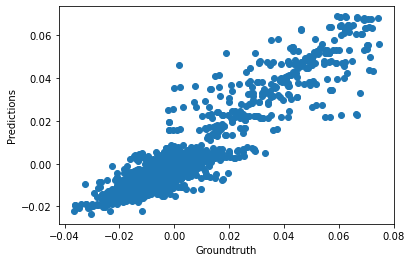

In [53]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [44]:
#%store model_fr_com_x

In [45]:
#for idx, prediction in enumerate(predictions):
#    print(f'Command: {X_test[idx, :3]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [46]:
# Save model
#joblib.dump(model_fr_com_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fr_com_x.sav")

## Predict CoM -> y

### Linear Regression

In [93]:
# Input
X = np.hstack((X_motion_CoM_acc_FR_RL[:, :3], # previous motion command
               X_motion_CoM_acc_FR_RL[:, -3:], # commanded motion command
               X_motion_CoM_acc_FR_RL[:, 9:11], # FL (x,y) position
               X_motion_CoM_acc_FR_RL[:, 12:14], # FR (x,y) position
               X_motion_CoM_acc_FR_RL[:, 15:17], # RL (x,y) position
               X_motion_CoM_acc_FR_RL[:, 18:20])) # RR (x,y) position

# Labels
Y = np.array([Y_motion_CoM_acc_FR_RL[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True)

# Create the model
model_fr_com_y = LinearRegression()

# Fit the model
model_fr_com_y.fit(X_train, Y_train)

# Predict
predictions = model_fr_com_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9056427098894885
RMSE:  0.012062572344439132
The lowest error is:  2.7854237255181546e-06
The highest error is:  0.057496685960011236
The avg. error is:  0.008343267022153893


In [94]:
model_fr_com_y.coef_

array([[ 0.01804221,  0.13285808,  0.1493604 , -0.01451485,  0.04431237,
         0.05506978, -0.143388  ,  0.00765765,  0.15110374, -0.14170376,
        -0.14938378,  0.00959972,  0.26213222,  0.19404234]])

In [95]:
model_fr_com_y.intercept_

array([0.03642354])

Text(0, 0.5, 'Predictions')

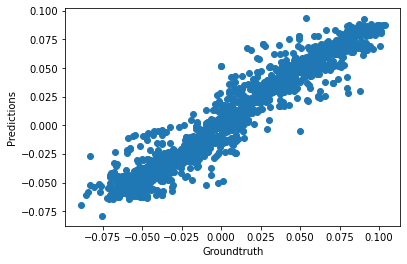

In [96]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [42]:
#%store model_fr_com_y

In [43]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [44]:
# Save model
#joblib.dump(model_fr_com_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fr_com_y.sav")